In [38]:
# Importação das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import requests
import pickle

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [39]:
# Carrega o arquivo CSV

#path = './data/dataset_desafio_fadesp.csv'
path = 'https://raw.githubusercontent.com/ricmed/desafio-fadesp-processo-seletivo/master/data/dataset_desafio_fadesp.csv'
df = pd.read_csv(path, encoding='ISO-8859-1', sep=',')
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [41]:
# Convertendo as colunas para os tipos corretos
df['Order Date'] = df['Order Date'].str.replace('-','/')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

df['Ship Date'] = df['Ship Date'].str.replace('-','/')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [42]:
# A variável Postal Code possui 80% de valores nulos, então será excluída
df['Postal Code'].isna().sum()/len(df)*100

80.51472021836615

In [43]:
df.drop(columns='Postal Code', inplace=True)

In [44]:
# As colunas Row ID e Order ID não são relevantes para a análise e serão excluídas
df.drop(columns=['Row ID', 'Order ID'], inplace=True)

In [45]:
# Verificando duplicados
df.duplicated().sum()

0

In [46]:
# Verificando valores NA
df.isnull().sum()

Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping Cost     0
Order Priority    0
dtype: int64

In [47]:
df.describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,246.490581,3.476545,0.142908,28.610982,26.375915
std,487.565361,2.278766,0.212280,174.340972,57.296804
min,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,30.758625,2.000000,0.000000,0.000000,2.610000
50%,85.053000,3.000000,0.000000,9.240000,7.790000
75%,251.053200,5.000000,0.200000,36.810000,24.450000
max,22638.480000,14.000000,0.850000,8399.976000,933.570000


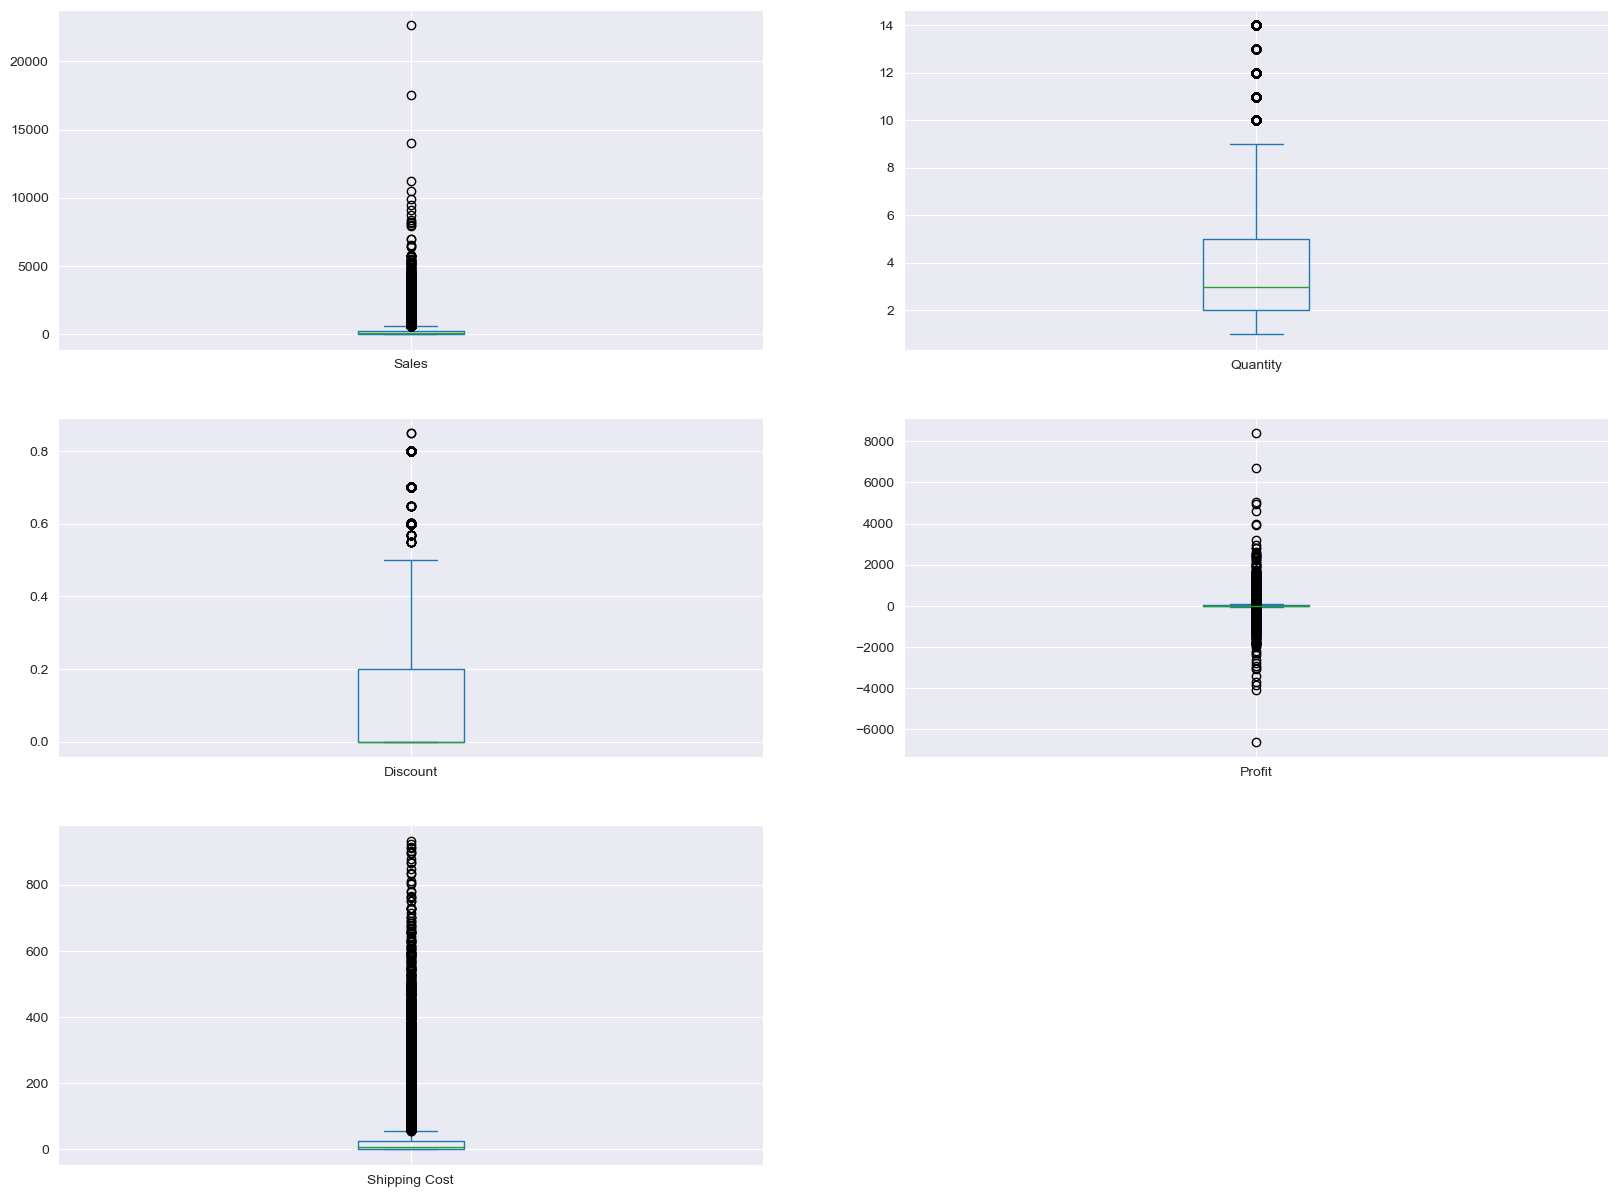

In [48]:
# Análise exploratória

# Box Plots
df[['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']].plot(kind='box', subplots=True, layout=(3,2), sharex=False, sharey=False, figsize=(20,15))
plt.show()

- Verificamos a existência de outliers em todas as veriáveis listadas.
- A variável Profit possui valores negativos. Esse comportamento pode não ser erro, já que produtos podem ser vendidos abaixo do preço de custo, por várias razões.

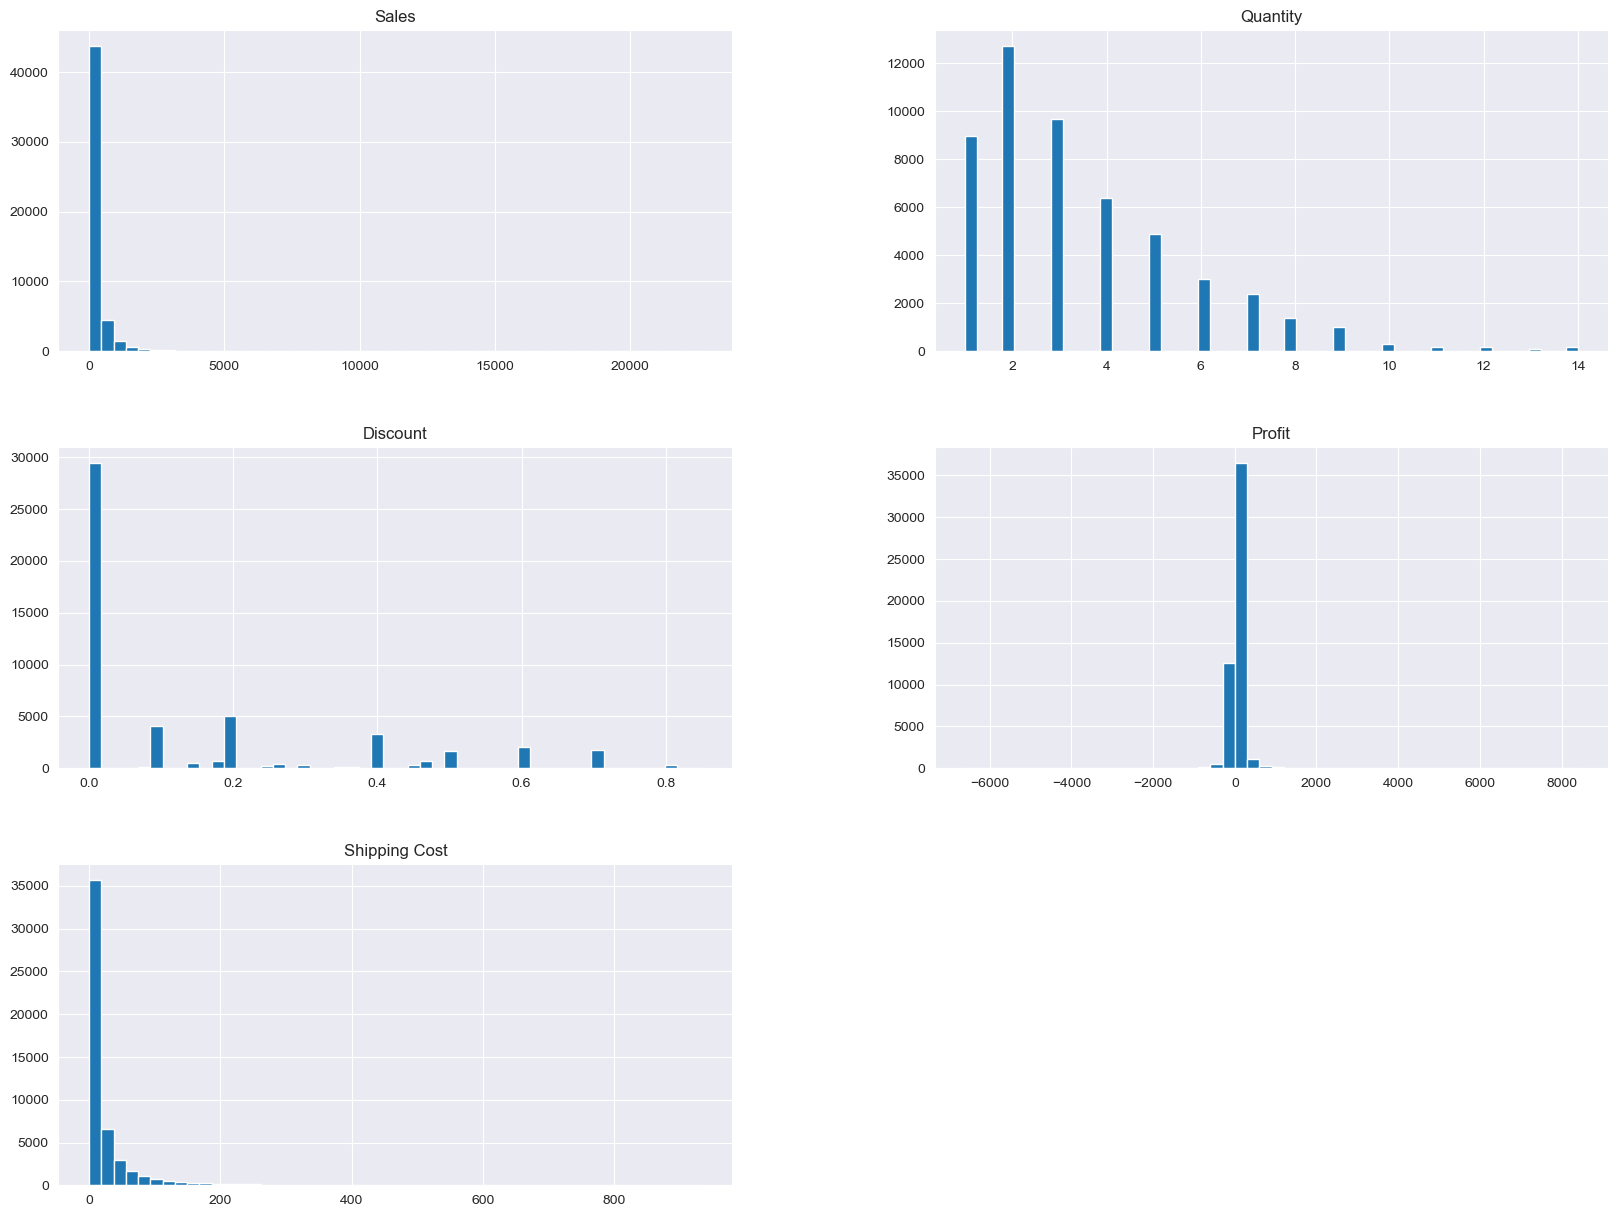

In [49]:
# Gráficos de frequência

df[['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']].hist(bins=50, figsize=(20,15))
plt.show()

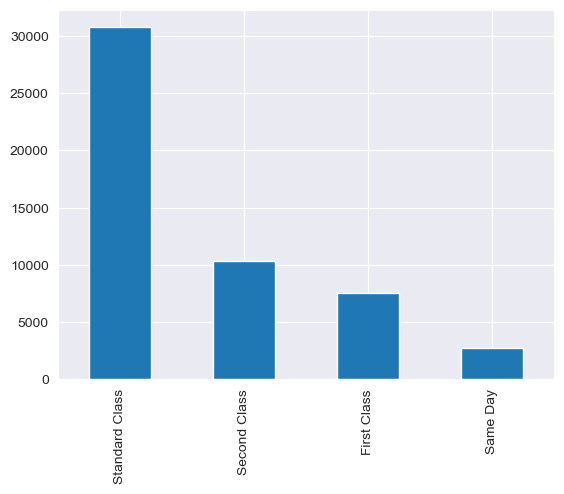

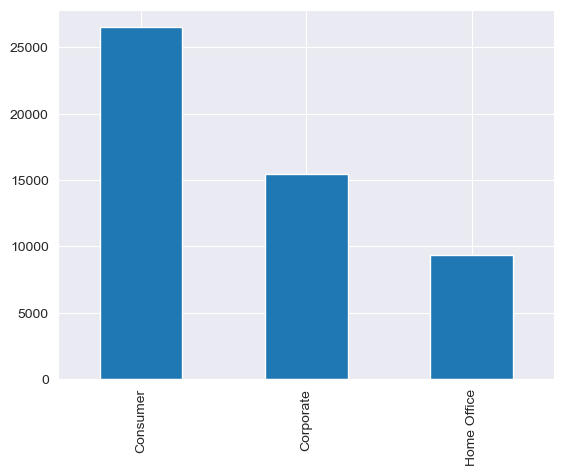

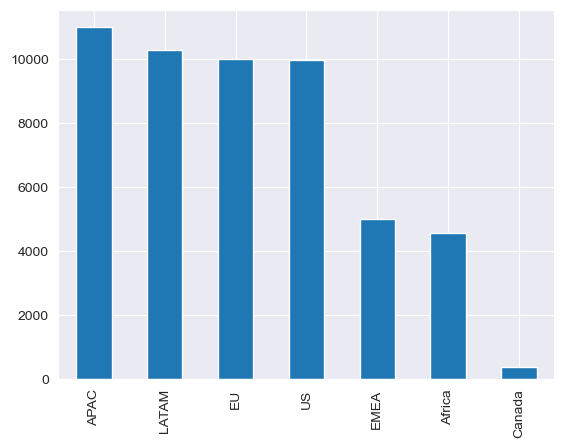

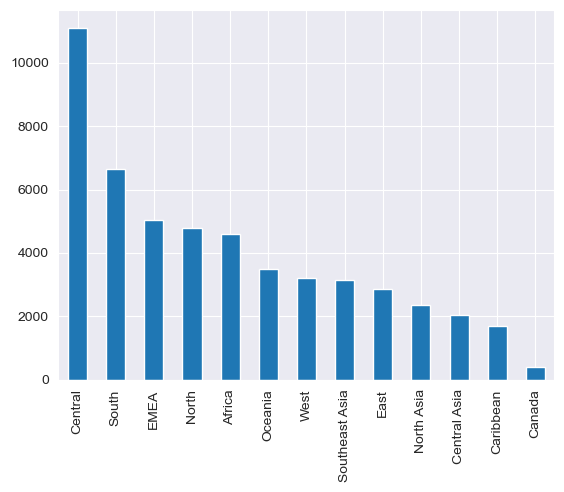

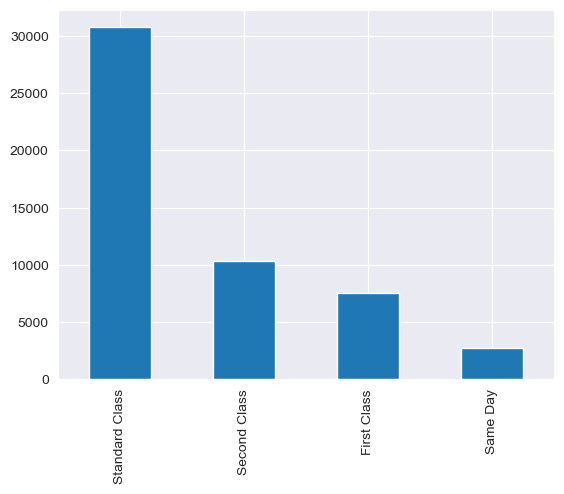

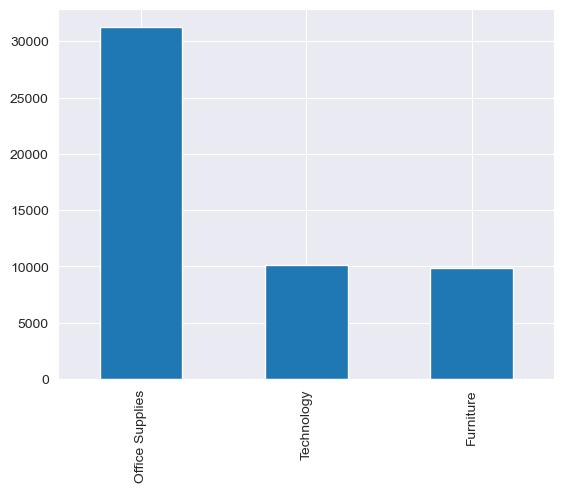

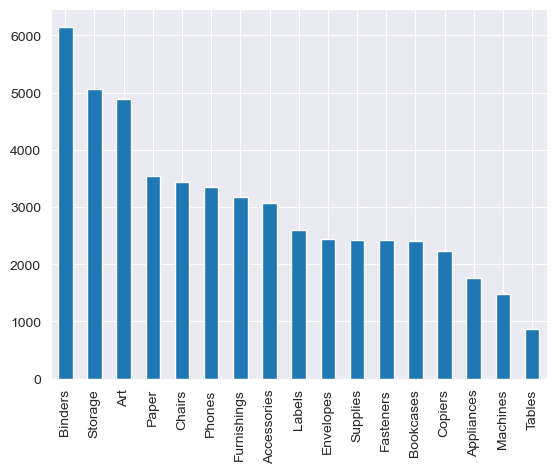

In [50]:
# Gráficos de Barras
df['Ship Mode'].value_counts().plot(kind='bar')
plt.show()

df['Segment'].value_counts().plot(kind='bar')
plt.show()

df['Market'].value_counts().plot(kind='bar')
plt.show()

df['Region'].value_counts().plot(kind='bar')
plt.show()

df['Ship Mode'].value_counts().plot(kind='bar')
plt.show()

df['Category'].value_counts().plot(kind='bar')
plt.show()

df['Sub-Category'].value_counts().plot(kind='bar')
plt.show()

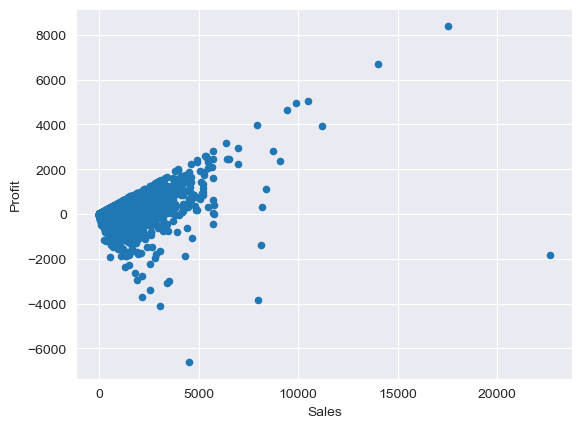

<Axes: xlabel='Discount', ylabel='Sales'>

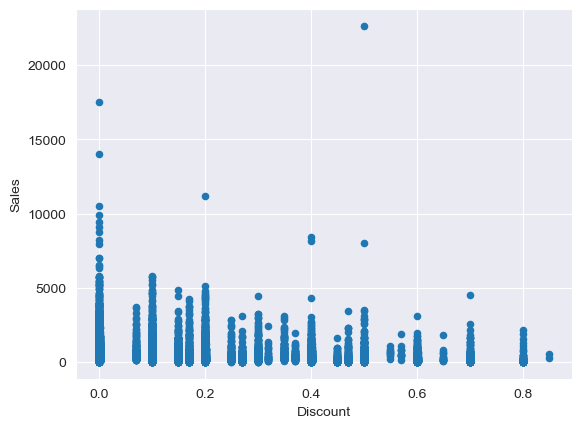

In [51]:
# Gráfico de Dispersão
df.plot(kind='scatter', x='Sales', y='Profit')
plt.show()

df.plot(kind='scatter', x='Discount', y='Sales')

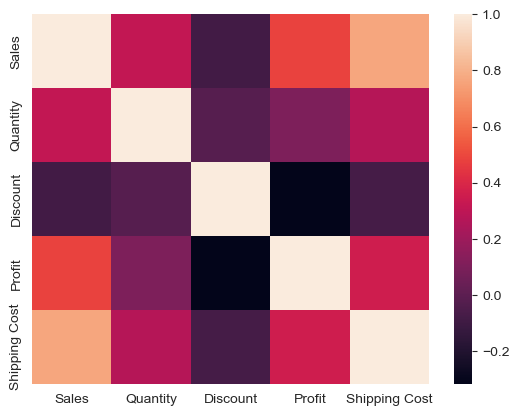

In [52]:
# Matriz de Correlação
corr_matrix = df[['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']].corr()
sns.heatmap(corr_matrix)
plt.show()

- Não é possível verificar a correlação entre tempo de entrega e o preço dos produtos, pois não existe uma coluna com data de entrega e nem uma forma de calcular. Só temos disponível no dataset as variáveis Order Date (Data do pedido) e Ship Date (Data do envio) 

In [53]:
# Produtos mais vendidos

produtos_mais_vendidos = df.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False)
produtos_mais_vendidos = pd.DataFrame(produtos_mais_vendidos.head(5))
produtos_mais_vendidos

,Quantity
Product Name,
Staples,876
"Cardinal Index Tab, Clear",337
"Eldon File Cart, Single Width",321
"Rogers File Cart, Single Width",262
"Sanford Pencil Sharpener, Water Color",259


In [54]:
# Distribuição geográfica dos produtos mais vendidos

top_venda_produtos = df[ df['Product Name'].isin(produtos_mais_vendidos.index)]

df_agrupado_top_vendas = top_venda_produtos.groupby(['Region', 'Product Name']).agg({'Quantity': sum}).reset_index()

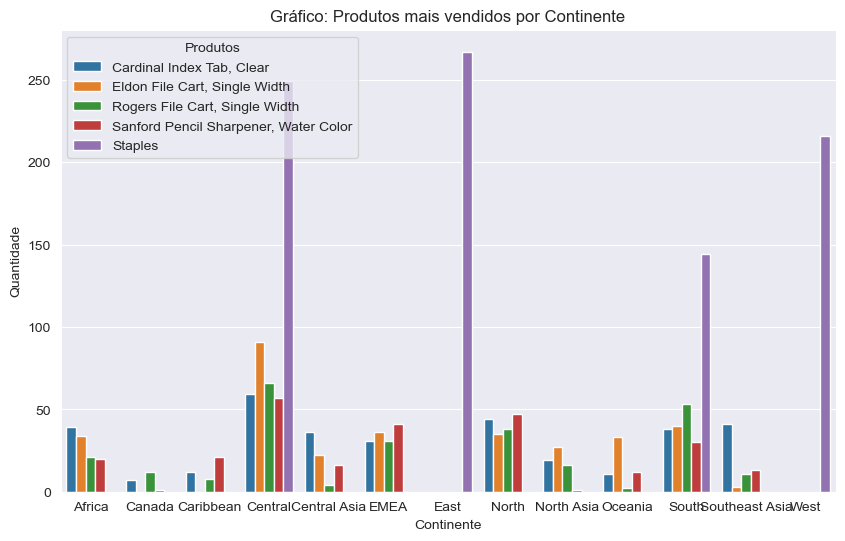

In [55]:
# Gráfico de barras 
plt.figure(figsize=(10,6))
sns.barplot(x='Region', y='Quantity', hue='Product Name', data=df_agrupado_top_vendas, errorbar=None)
plt.title('Gráfico: Produtos mais vendidos por Continente')
plt.xlabel('Continente')
plt.ylabel('Quantidade')
plt.legend(title='Produtos')
plt.show()

- DESAFIOS

In [56]:
# Realize o processo de extração do dataset diretamente a partir do repositório do github utilizando Python.

url = 'https://raw.githubusercontent.com/ricmed/desafio-fadesp-processo-seletivo/master/data/dataset_desafio_fadesp.csv'
response = requests.get(url)
response = requests.get(url)
data = StringIO(response.text)

df_novo =  pd.read_csv(data, encoding='ISO-8859-1')
df_novo.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [57]:
# Armazene o dataset em um banco de dados chave-valor SQLite e realize consultas em SQL nestes dados.

# Cria uma conexão com o banco de dados SQLite
# Se o banco de dados não existir, ele será criado
conn = sqlite3.connect('desafio_fadesp.db')

# Armazena o DataFrame do pandas no banco de dados SQLite
df_novo.to_sql('vendas', conn, if_exists='replace', index=False)

# Realiza consultas SQL
query = ("SELECT * "
         "FROM vendas "
         "WHERE Sales > 4000")
df_query = pd.read_sql_query(query, conn)
df_query.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,34577,CA-2011-102988,5/4/2011,9/4/2011,Second Class,GM-14695,Greg Maxwell,Corporate,Alexandria,Virginia,...,OFF-SU-10002881,Office Supplies,Supplies,Martin Yale Chadless Opener Electric Letter Op...,4164.050,5,0.00,83.281,846.54,High
1,11611,ES-2011-4500805,5/11/2011,9/11/2011,Second Class,PO-18865,Patrick O'Donnell,Consumer,Nice,Provence-Alpes-C�te d'Azur,...,TEC-PH-10002623,Technology,Phones,"Cisco Smart Phone, with Caller ID",4448.832,8,0.15,1517.712,527.85,High
2,20861,IN-2011-64326,7/6/2011,11/6/2011,Second Class,DR-12940,Daniel Raglin,Home Office,Townsville,Queensland,...,OFF-AP-10003917,Office Supplies,Appliances,"KitchenAid Stove, Silver",4624.290,9,0.10,1644.030,427.46,Medium
3,31462,CA-2011-139892,8/9/2011,12/9/2011,Standard Class,BM-11140,Becky Martin,Consumer,San Antonio,Texas,...,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.40,-1359.992,342.11,Medium
4,13560,ES-2011-3248922,8/9/2011,11/9/2011,Second Class,ER-13855,Elpida Rittenbach,Corporate,Lugo,Galicia,...,OFF-AP-10002330,Office Supplies,Appliances,"Hamilton Beach Stove, Silver",6517.080,12,0.00,2476.440,28.74,Critical


In [58]:
conn.close()


# Modelo de Regressão

In [59]:
# Removendo as colunas de IDs e de datas e criando um novo df para aplicar a regressão

df_reg = df.drop(columns=['Customer ID', 'Customer Name', 'Product ID', 'Order Date', 'Ship Date'])
df_reg.head()

,Ship Mode,Segment,City,State,Country,Market,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,Standard Class,Consumer,Constantine,Constantine,Algeria,Africa,Africa,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,Standard Class,Consumer,Wagga Wagga,New South Wales,Australia,APAC,Oceania,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,Second Class,Consumer,Budapest,Budapest,Hungary,EMEA,EMEA,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,Second Class,Home Office,Stockholm,Stockholm,Sweden,EU,North,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,Standard Class,Consumer,Wagga Wagga,New South Wales,Australia,APAC,Oceania,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [60]:
# Analisando as variáveis categóricas
colunas_categoricas = df_reg.select_dtypes(include= 'object').columns

def convert_categoria(df: pd.DataFrame, colunas):
    for coluna in colunas:
        df[coluna] = df[coluna].astype('category')
    return df 

def conta_categorias(df: pd.DataFrame, colunas):
    for coluna in colunas:
        qtd = df.value_counts(subset=[coluna]).count()
        print(f'A quantidade de categorias da variável {coluna} é de: {qtd}')

df_reg = convert_categoria(df_reg, colunas_categoricas)

conta_categorias(df_reg, colunas_categoricas)

A quantidade de categorias da variável Ship Mode é de: 4
A quantidade de categorias da variável Segment é de: 3
A quantidade de categorias da variável City é de: 3636
A quantidade de categorias da variável State é de: 1094
A quantidade de categorias da variável Country é de: 147
A quantidade de categorias da variável Market é de: 7
A quantidade de categorias da variável Region é de: 13
A quantidade de categorias da variável Category é de: 3
A quantidade de categorias da variável Sub-Category é de: 17
A quantidade de categorias da variável Product Name é de: 3788
A quantidade de categorias da variável Order Priority é de: 4


- Devido a grande quantidade de categorias e para não almentar muito a cardinalidade vamos elimiar as colunas City, State, Product Name
- Como Category está correlacionada com Sub-Category, vamo manter somente a Category

In [61]:
df_reg.drop(columns=['City', 'State', 'Product Name', 'Sub-Category'], inplace=True)
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Ship Mode       51290 non-null  category
 1   Segment         51290 non-null  category
 2   Country         51290 non-null  category
 3   Market          51290 non-null  category
 4   Region          51290 non-null  category
 5   Category        51290 non-null  category
 6   Sales           51290 non-null  float64 
 7   Quantity        51290 non-null  int64   
 8   Discount        51290 non-null  float64 
 9   Profit          51290 non-null  float64 
 10  Shipping Cost   51290 non-null  float64 
 11  Order Priority  51290 non-null  category
dtypes: category(7), float64(4), int64(1)
memory usage: 2.4 MB


In [62]:
# Verificando o balanceamento das categorias
colunas = df_reg.select_dtypes(include= 'category').columns

def categorias_percentual (df: pd.DataFrame, colunas):
    for coluna in colunas:
        print(f"Para a veriável {coluna}")
        print(df.value_counts(subset=[coluna], normalize=True))
        print("\n")

categorias_percentual(df_reg, colunas)

Para a veriável Ship Mode
Ship Mode     
Standard Class    0.600019
Second Class      0.200994
First Class       0.146325
Same Day          0.052661
dtype: float64


Para a veriável Segment
Segment    
Consumer       0.517021
Corporate      0.300819
Home Office    0.182160
dtype: float64


Para a veriável Country
Country      
United States    0.194853
Australia        0.055313
France           0.055118
Mexico           0.051550
Germany          0.040261
                   ...   
Eritrea          0.000039
Swaziland        0.000039
Burundi          0.000039
Chad             0.000039
Bahrain          0.000039
Length: 147, dtype: float64


Para a veriável Market
Market
APAC      0.214506
LATAM     0.200702
EU        0.194970
US        0.194853
EMEA      0.098050
Africa    0.089433
Canada    0.007487
dtype: float64


Para a veriável Region
Region        
Central           0.216748
South             0.129557
EMEA              0.098050
North             0.093293
Africa            0.089433
Oc

- Podemos perceber o desbalanceamento nas variáveis, mas não vamos tratar este aspecto para esta análise

In [63]:
# criando variáveis dummies
df_reg = pd.get_dummies(df_reg, drop_first=True)

In [64]:
# Normalizando as variáveis

colunas_norm = ['Quantity', 'Discount', 'Shipping Cost']

scaler = MinMaxScaler()
df_reg[colunas_norm] = pd.DataFrame(scaler.fit_transform(df_reg[colunas_norm]))
df_reg.head(3)

,Sales,Quantity,Discount,Profit,Shipping Cost,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Category_Office Supplies,Category_Technology,Order Priority_High,Order Priority_Low,Order Priority_Medium
0,408.300,0.076923,0.000000,106.140,0.037983,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,120.366,0.153846,0.117647,36.036,0.010412,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
2,66.120,0.230769,0.000000,29.640,0.008751,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [65]:
df_reg.corr()
correlacoes = df_reg.corr(numeric_only=True)['Sales'].sort_values()


In [66]:
# Vertificando as variáveis com correlação mais significante, vamos utilizar (de forma simplificada)somente este critério para identificar as melhores variáveis para o modelo

c = correlacoes[(correlacoes > 0.20) | (correlacoes < -0.20)]
c.index

Index(['Category_Office Supplies', 'Category_Technology', 'Quantity', 'Profit',
       'Shipping Cost', 'Sales'],
      dtype='object')

In [67]:
df_reg = df_reg[['Category_Office Supplies', 'Category_Technology', 
                 'Quantity', 'Profit', 'Shipping Cost', 'Sales']]
df_reg.head()


,Category_Office Supplies,Category_Technology,Quantity,Profit,Shipping Cost,Sales
0,1,0,0.076923,106.140,0.037983,408.300
1,1,0,0.153846,36.036,0.010412,120.366
2,1,0,0.230769,29.640,0.008751,66.120
3,1,0,0.153846,-26.055,0.005163,44.865
4,0,0,0.307692,37.770,0.005034,113.670


In [68]:
# Definindo os datasets para o modelo

X = df_reg.drop('Sales', axis=1)
y = df_reg['Sales']

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cria e treina o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcula as métricas de erro
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r_2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r_2}%')

MSE: 125554.40208995137
MAE: 117.13172980412813
MAPE: 122.57003872935009%
R²: 0.5175911251160386%


In [69]:
# Salva o modelo
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model, file)